<font size="6"><i>This code illustrates the implementation of <b>neural prophet for time series forecasting</b>. Neural prophet is a AR-net (AutoRegressive Neural Network) based implementation on top of FB/ Meta prophet, which is a popular and easy to use forecasting library. For this exercise, we will use [ETTm2 dataset](https://raw.githubusercontent.com/ankursikka/Impact-DS/main/Time-Series-Forecasts/ETTm2.csv) that contains measurement of oil temperature and variants of load for an electricity transformer in China.</i></font>

<font size=6><i><b>Note: This notebook contains chart built using plotly and thus the recommended method to view this is using [notebook viewer here](https://nbviewer.org/github/ankursikka/Impact-DS/blob/main/Time-Series-Forecasts/NeuralProphet/Forecast_NeuralProphet_v1.ipynb) </b><i></font>

<hr>

In [1]:
# Importing necessary modules

import pandas as pd
import numpy as np

from neuralprophet import NeuralProphet, set_random_seed, set_log_level
set_log_level("ERROR") # Disable logging messages unless there is an error

import warnings
warnings.filterwarnings("ignore") # Suppress all warnings

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import statsmodels.tsa.seasonal as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from IPython.display import Image, display
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlib inline

# Setting display options

pd.set_option('display.width',1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', 800)
plt.style.use('fivethirtyeight')

<font size=6><i><b>Part 1: Importing the data and doing some pre-processing as well as EDA</b><i></font>

In [2]:
# Import the data

df = pd.read_csv('https://raw.githubusercontent.com/ankursikka/Impact-DS/main/Time-Series-Forecasts/ETTm2.csv')

In [3]:
# Let us look at the top rows

df.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,41.130001,12.481,36.535999,9.355,4.424,1.311,38.661999
1,2016-07-01 00:15:00,39.622002,11.309,35.543999,8.551,3.209,1.258,38.223000
2,2016-07-01 00:30:00,38.868000,10.555,34.365002,7.586,4.435,1.258,37.344002
3,2016-07-01 00:45:00,35.518002,9.214,32.569000,8.712,4.435,1.215,37.124001
4,2016-07-01 01:00:00,37.528000,10.136,33.936001,7.532,4.435,1.215,37.124001


In [4]:
# Let us map full column names to column abbreviations

df2 = df.copy(deep=True)
df2 = df2.rename(columns={'date':'ds',  # neural prophet requires date/ timestamp to be named as column 'ds'
                                  'HUFL':'High_Useful_Load',
                                  'HULL':'High_Useless_Load',
                                  'MUFL':'Middle_Useful_Load',
                                  'MULL':'Middle_Useless_Load',
                                  'LUFL':'Low_Useful_Load',
                                  'LULL':'Low_Useless_Load',
                                  'OT':'y'}) # 'Oil Temperature; Target variable; neural prophet requires target to be named as columns 'y'

In [5]:
# Checking field types

df2.dtypes

ds                      object
High_Useful_Load       float64
High_Useless_Load      float64
Middle_Useful_Load     float64
Middle_Useless_Load    float64
Low_Useful_Load        float64
Low_Useless_Load       float64
y                      float64
dtype: object

In [6]:
# Changing date to datetime

df2.ds = pd.to_datetime(df2.ds)

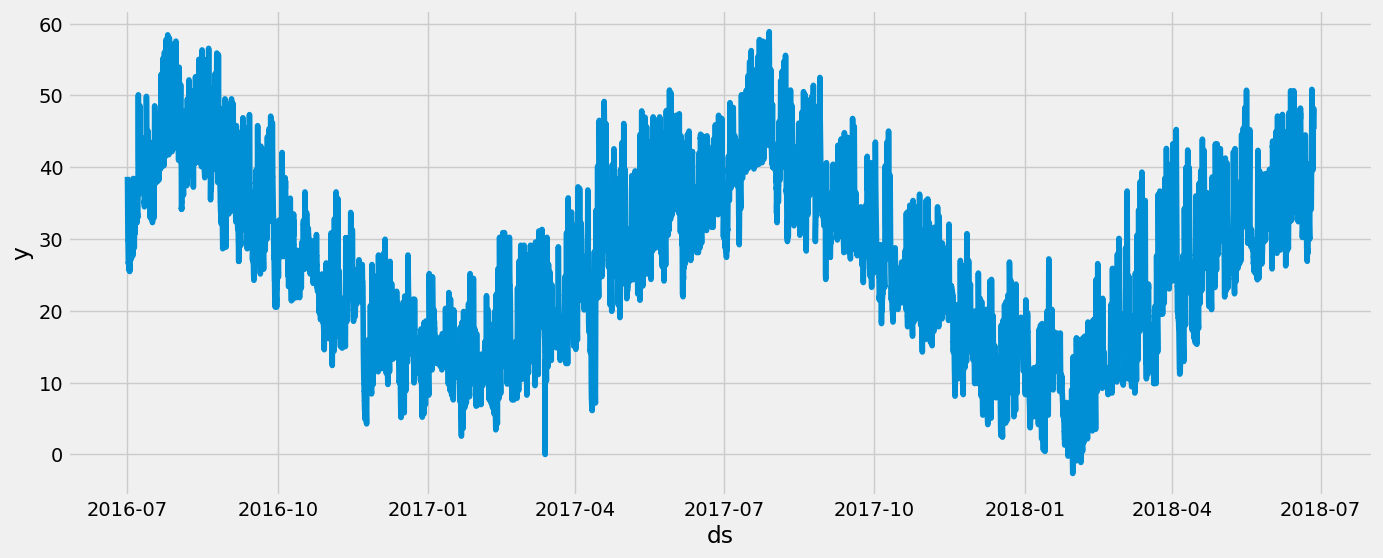

In [7]:
# Checking target

plt.figure(figsize=(15,6))
sns.lineplot(data=df2,x='ds',y='y')
plt.show()


<b><i>From an aggregate perspective, it doesn't appear to have a trend. But there is definite additive seasonality which we will also see in the components of the forecast later.</i></b>

In [8]:
# Creating a copy of dataframe for decomposing and plottng trend and seasonality components

df3 = df2[['ds','y']].copy(deep=True)
df3.set_index('ds',inplace=True)
df3.head()

,y
ds,
2016-07-01 00:00:00,38.661999
2016-07-01 00:15:00,38.223000
2016-07-01 00:30:00,37.344002
2016-07-01 00:45:00,37.124001
2016-07-01 01:00:00,37.124001


In [9]:
# Visually checking for seasonality/ periodicity

px.line(data_frame=df3, y='y')

FigureWidgetResampler({
    'data': [{'hovertemplate': 'ds=%{x}<br>y=%{y}<extra></extra>',
              'legendgroup': '',
              'line': {'color': '#636efa', 'dash': 'solid'},
              'marker': {'symbol': 'circle'},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b>  <i style="color:#fc9944">~17h</i>',
              'showlegend': False,
              'type': 'scattergl',
              'uid': '7e118d16-d8c3-4572-856b-a7f8efcb6317',
              'x': array([datetime.datetime(2016, 7, 1, 0, 0),
                          datetime.datetime(2016, 7, 1, 9, 30),
                          datetime.datetime(2016, 7, 2, 8, 30), ...,
                          datetime.datetime(2018, 6, 25, 14, 30),
                          datetime.datetime(2018, 6, 26, 5, 0),
                          datetime.datetime(2018, 6, 26, 19, 45)], dtype=object),
              'xaxis': 'x',
              'y': array([38.66199875, 27.67550087, 25.47850037, ..., 50.84

<b><i>Seeing it visually using plotly lineplot by zooming in, we can see that there is a daily seasonality</i></b>

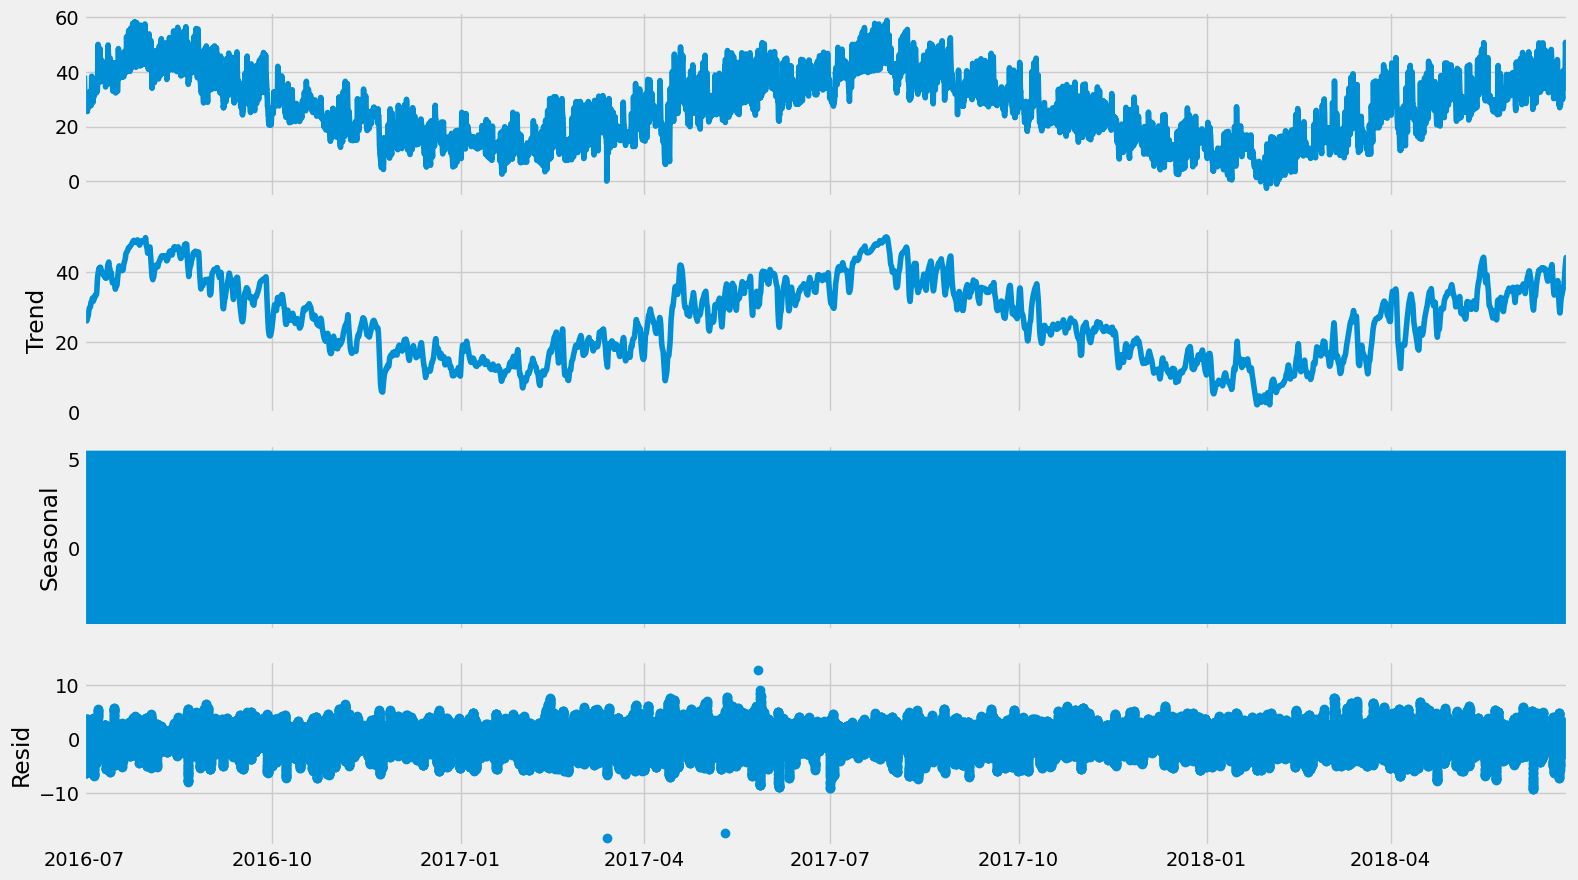

In [10]:
# Let us plot all components of this data

decomp=  sm.seasonal_decompose(df3,model='additive',period=4*24) # 4 points per hour * 24 hours
# Although this data is at 15 minute frequency, we are decomposing this using 1 day period
# We can change and resample data to higher frequencies as needed

splot = decomp.plot()
splot.set_size_inches((16,9))
splot.tight_layout()
splot.show()


<b><i>If we put all the data, the seasonal component does not show properly and it is all smudged together</i></b>

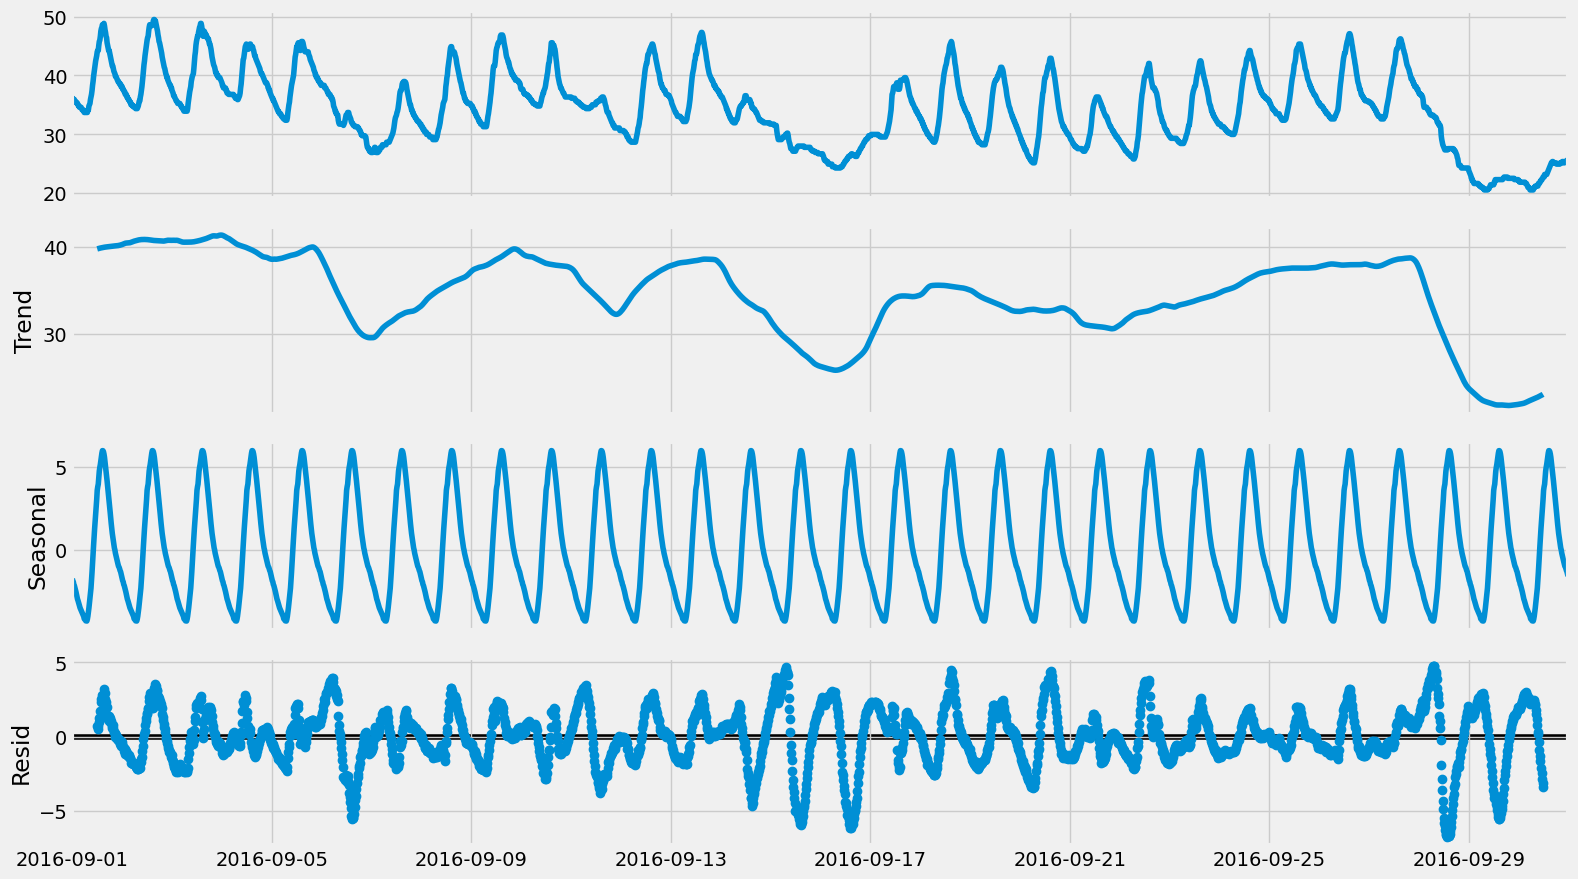

In [11]:
decomplimit=  sm.seasonal_decompose(df3.loc['2016-09'],model='additive',period=4*24) 
# Although this data is at 15 minute frequency, we are decomposing this using 1 day period
# We can change and resample data to higher frequencies as needed

splot = decomplimit.plot()
splot.set_size_inches((16,9))
splot.tight_layout()
splot.show()

<b><i>Decomposing only a month of data shows clear seasonality!</i></b>

<hr>

<font size=6><i><b>Part 2: Building baseline model with no external regressors</b><i></font>

In [12]:
# Setting the model and fit parameters 

Params = dict(yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', learning_rate=0.01) # Dictionary storing key parameters for model

fitparams = dict(epochs=50, freq='15min', early_stopping=10, progress='plot') # Dictionary storing key parameters for fitting

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.011954620480537415
         MAE_val             5.742470741271973
        RMSE_val             6.690657138824463
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.15528078377246857
         MAE_val              20.92919921875
        RMSE_val             21.55363655090332
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.17267806828022003
         MAE_val               25.8017578125
        RMSE_val            26.126094818115234
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.05148279666900635
         MAE_val            10.948493003845215
        RMSE_val            11.736470222473145
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.32721057534217834
         MAE_val             36.04435348510742
        RMSE_val             36.48705291748047
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


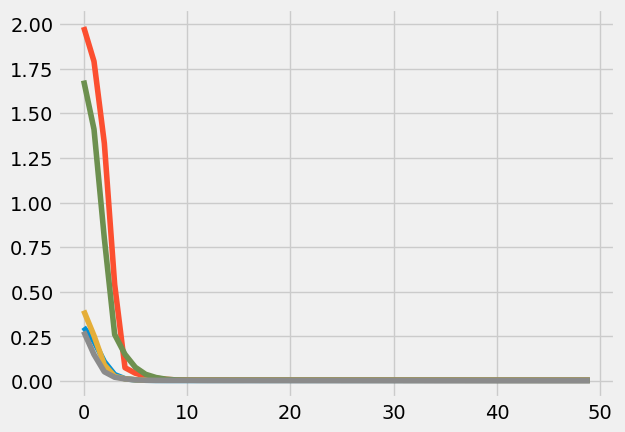

In [13]:
# Building, training and cross validating the model

def basemodel(Params, fitparams):

     dfcv = NeuralProphet(**Params).crossvalidation_split_df(df2[['ds','y']], k=5, fold_pct=0.2) # Splitting data into test and validation sets

     summary = pd.DataFrame()
     metrics = pd.DataFrame()
     i=0

     set_random_seed(50) # For reproducibility

     for dftrain, dfval in dfcv: # Run for number of cross validation folds
          mp = NeuralProphet(**Params) # Initialize with yearly seasonality and learning rate
          summary = pd.concat([summary, mp.fit(dftrain, **fitparams)]) # Fitting model to training fold and storing results in summary df
          
          metrics = pd.concat([metrics,mp.test(dfval)]) # Validation for each fold and storing results in metrics df

          i=i+1


     return summary, metrics

summaryb, metricsb = basemodel(Params, fitparams)

In [14]:
# Function to display model performance stats

def statdisp(x,y):

    # Checking the model performance against training folds

    print('Training folds\n\n', x.describe())

    # Evaluating the model performance against validation folds

    print('\n\nValidation folds\n\n', y.describe())

    return None

statdisp(summaryb, metricsb)

Training folds

               MAE        RMSE        Loss  RegLoss       epoch
count  250.000000  250.000000  250.000000    250.0  250.000000
mean     8.188535    9.868427    0.052290      0.0   24.500000
std     18.572892   20.344647    0.241981      0.0   14.459818
min      3.344748    4.225350    0.003109      0.0    0.000000
25%      3.534152    4.508456    0.003455      0.0   12.000000
50%      3.724777    4.733130    0.003940      0.0   24.500000
75%      3.919814    4.995558    0.004371      0.0   37.000000
max    140.915054  154.807053    1.983205      0.0   49.000000


Validation folds

          MAE_val   RMSE_val  Loss_test  RegLoss_test
count   5.000000   5.000000   5.000000           5.0
mean   19.893255  20.518782   0.143721           0.0
std    12.011401  11.788178   0.122995           0.0
min     5.742471   6.690657   0.011955           0.0
25%    10.948493  11.736470   0.051483           0.0
50%    20.929199  21.553637   0.155281           0.0
75%    25.801758  26.126

<b><i><font size=5>We see that the model has a decent performance with RMSE/ MAE in single digits, and a mean RMSE of ~ 10. However, it does not perform as well on unseen data, and we observe a mean RMSE of ~ 20.5 with max being ~ 36.5.

What this means is that the model is actually overfitting the in-sample (test) data, and will not give best out-of-sample forecast.</font></i></b>

In [15]:
# Training the model using the entire available data

Params = dict(yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', learning_rate=0.01) # Dictionary storing key parameters for model

fitparams = dict(epochs=50, freq='15min', early_stopping=10, progress='plot') # Dictionary storing key parameters for fitting

In [16]:
# Creating a function for model

def alldatamodel(Params, fitparams):

    set_random_seed(50) # For reproducibility

    m = NeuralProphet(**Params)
    m.fit(df2[['ds','y']], **fitparams)

    return m

Training: 0it [00:00, ?it/s]

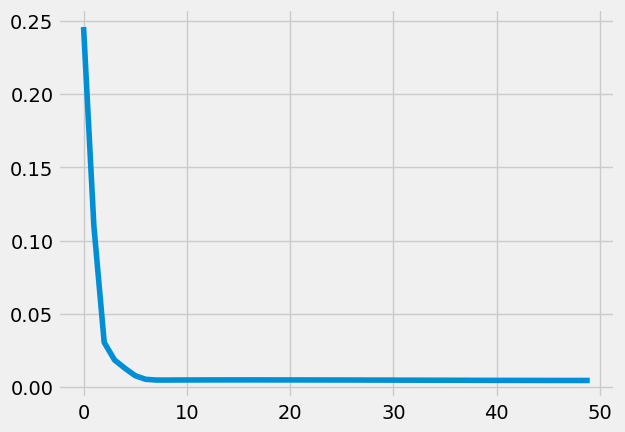

In [17]:
# Calling the function and training the model

model = alldatamodel(Params,fitparams)

In [18]:
# Checking against current dataframe, on how well it is performing

# model.set_plotting_backend("plotly-resampler") # show plots correctly in jupyter notebooks

current = model.predict(df2[['ds','y']])
fig=model.plot(current)
fig.update_layout(autosize=False, width=1200, height=800)


Predicting: 1089it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~17h</i>',
              'type': 'scatter',
              'uid': '101c1dd6-4576-4ae7-844b-7cbb4da82b1f',
              'x': array([datetime.datetime(2016, 7, 1, 0, 0),
                          datetime.datetime(2016, 7, 1, 14, 45),
                          datetime.datetime(2016, 7, 2, 6, 15), ...,
                          datetime.datetime(2018, 6, 25, 14, 45),
                          datetime.datetime(2018, 6, 26, 6, 15),
                          datetime.datetime(2018, 6, 26, 19, 45)], dtype=object),
              'y': array([36.347229  , 43.17668915, 33.81342316, ..., 43.37080002, 34.08052063,
                          38.76216507])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
            

<b><i>We see the model fits well with a decent bias, but if we zoom in we see that it also has some variance and potentially needs tuning.</i></b>

In [19]:
# Plotting the model components

fig= model.plot_components(current)
fig.update_layout(autosize=False, width=1200, height=800)

FigureWidgetResampler({
    'data': [{'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~17h</i>',
              'showlegend': False,
              'type': 'scatter',
              'uid': 'cf8b20d2-10d9-4680-9d54-c36abddb3140',
              'x': array([datetime.datetime(2016, 7, 1, 0, 0),
                          datetime.datetime(2016, 7, 1, 5, 15),
                          datetime.datetime(2016, 7, 2, 1, 45), ...,
                          datetime.datetime(2018, 6, 25, 12, 45),
                          datetime.datetime(2018, 6, 26, 5, 15),
                          datetime.datetime(2018, 6, 26, 19, 45)], dtype=object),
              'xaxis': 'x',
              'y': array([38.11772537, 38.14370728, 38.24517822, ..., 37.50385666, 37.60915375,
                          37.70166779]),
              'yaxis': 'y'},
             {'line': {'color': '#2d92ff', 'width': 2},


In [20]:
# Plotting just seasonal components

fig=model.plot_parameters(components='seasonality')
fig.update_layout(autosize=False, width=1200, height=800)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': 'weekly',
              'type': 'scatter',
              'uid': 'dc997088-85df-4eb4-bd23-e5037d796c0e',
              'x': array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
                           14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
                           28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
                           42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
                           56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
                           70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
                           84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
                           98,  99, 100, 101, 102, 103, 104, 

In [21]:
# Forecast future values from currently trained model

futuredf = model.make_future_dataframe(df2[['ds','y']], periods=4*24*7)
forecast = model.predict(futuredf)
print(forecast.head())

fig = model.plot(fcst=forecast)
fig.update_layout(autosize=False, width=1200, height=800)

Predicting: 1089it [00:00, ?it/s]

                   ds     y      yhat1      trend  season_weekly  season_daily
0 2018-06-26 20:00:00  None  38.518055  37.703262       0.168511      0.646282
1 2018-06-26 20:15:00  None  38.284161  37.704868       0.160000      0.419296
2 2018-06-26 20:30:00  None  38.063652  37.706448       0.151417      0.205787
3 2018-06-26 20:45:00  None  37.859215  37.708054       0.142767      0.008394
4 2018-06-26 21:00:00  None  37.672478  37.709648       0.134052     -0.171220


FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'yhat1',
              'type': 'scatter',
              'uid': '3235902a-b509-4313-a2ef-0b9f2693e34f',
              'x': array([datetime.datetime(2018, 6, 26, 20, 0),
                          datetime.datetime(2018, 6, 26, 20, 15),
                          datetime.datetime(2018, 6, 26, 20, 30), ...,
                          datetime.datetime(2018, 7, 3, 19, 15),
                          datetime.datetime(2018, 7, 3, 19, 30),
                          datetime.datetime(2018, 7, 3, 19, 45)], dtype=object),
              'y': array([38.51805496, 38.28416061, 38.06365204, ..., 40.34030151, 40.08517838,
                          39.83414459])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              

<hr>

<font size=6><i><b>Part 3: Improving the baseline model by adding and tuning parameters</b><i></font>

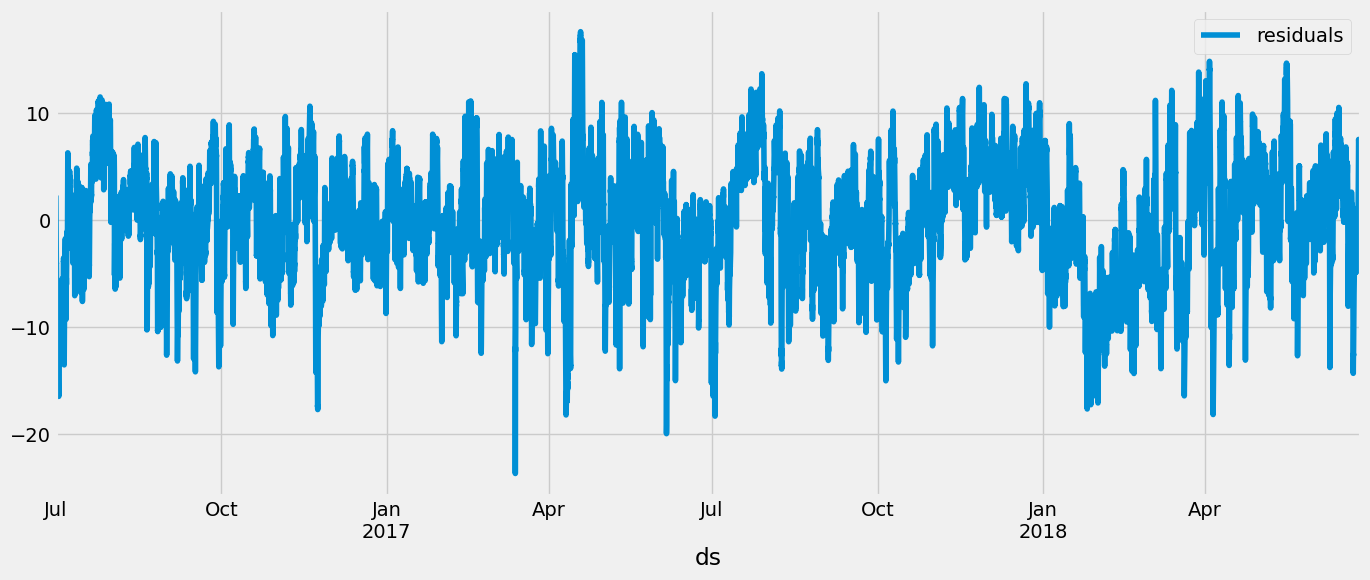

In [22]:
# Let us look at the residual in the baseline model for 'current' prediction

df_residuals = pd.DataFrame({"ds": df2["ds"], "residuals": df2["y"] - current["yhat1"]})
fig = df_residuals.plot(x="ds", y="residuals", figsize=(15, 6))

<b><i>There appears to be a lot of unexplained variance, which is apparent in residual.</i></b>

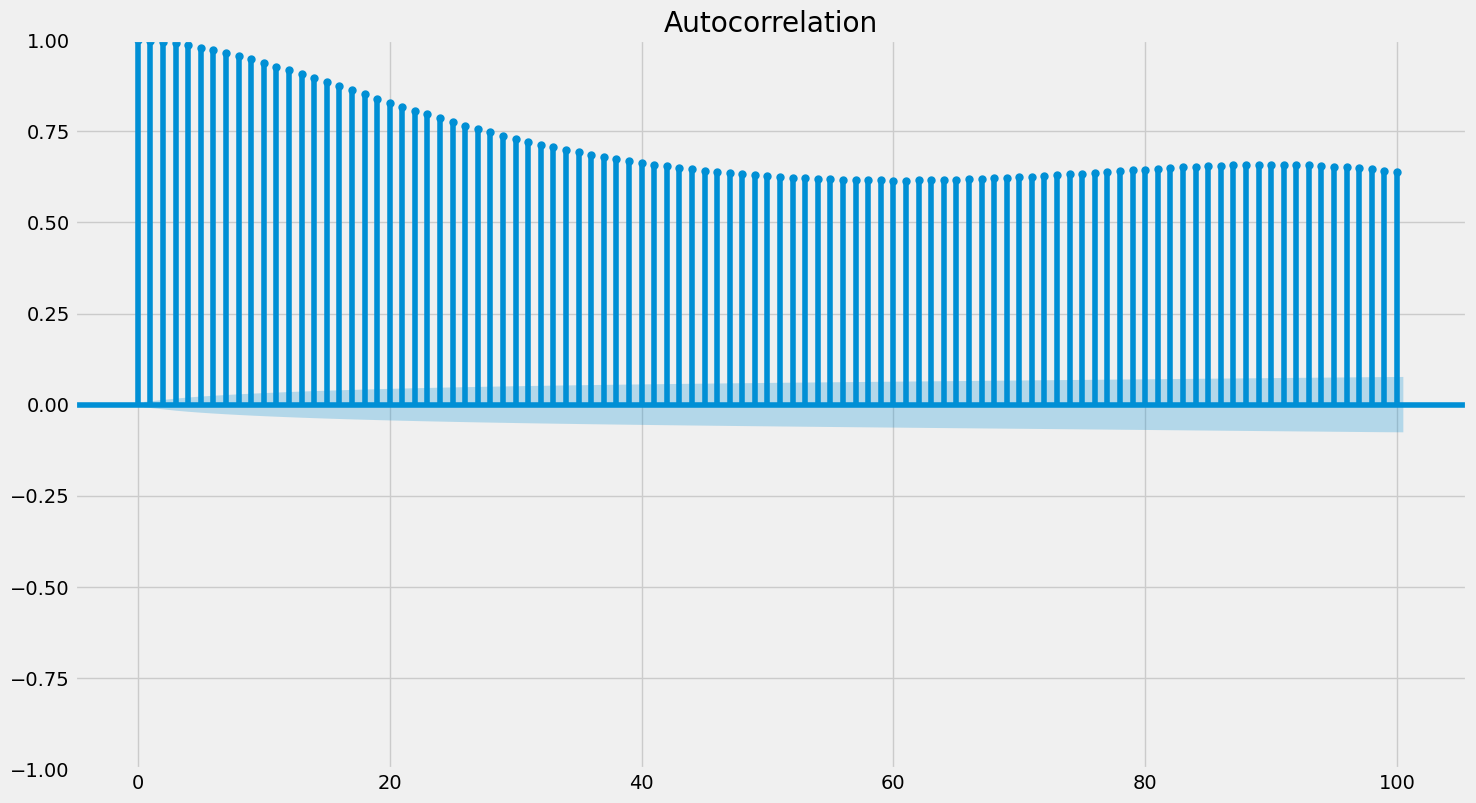

In [23]:
# Plotting Partial Auto-Correlation Function for the residuals

plt = plot_acf(df_residuals["residuals"], lags=100)
plt.set_size_inches((16,9))
plt.show()

<b><i>Looking at the Autocorrelation plot, we can see that the current target variable has a lot of dependence, direct as well as indirect, on the previous target values.</i></b>

Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          6.226957339094952e-05
         MAE_val            0.18903639912605286
        RMSE_val            0.3860457241535187
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test         1.9233804778195918e-05
         MAE_val            0.20943154394626617
        RMSE_val            0.2862009108066559
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test         1.1804528185166419e-05
         MAE_val            0.17852406203746796
        RMSE_val            0.23183846473693848
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          9.209992640535347e-06
         MAE_val            0.15461978316307068
        RMSE_val            0.20119483768939972
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test         1.5954818081809208e-05
         MAE_val            0.21764333546161652
        RMSE_val             0.273499071598053
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


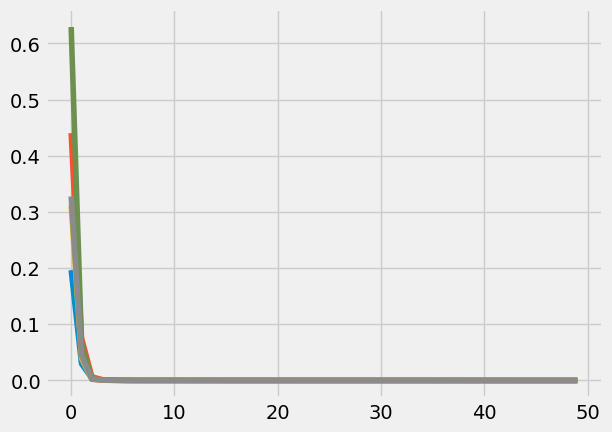

In [24]:
# Building, training and cross validating the model with Autoregression added

Params = dict(yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', learning_rate=0.01, n_lags=50) # Dictionary storing key parameters for model
# Adding n_lags to capture autoregression

fitparams = dict(epochs=50, freq='15min', early_stopping=10, progress='plot') # Dictionary storing key parameters for fitting

# Disable logging messages unless there is an error
set_log_level("ERROR")

summaryauto, metricsauto = basemodel(Params,fitparams) # Calling the function built previously to train the model


In [25]:
# Displaying the values after updating and training the model with autoregressor

statdisp(summaryauto, metricsauto)

Training folds

               MAE        RMSE        Loss  RegLoss       epoch
count  250.000000  250.000000  250.000000    250.0  250.000000
mean     1.490555    1.883114    0.008782      0.0   24.500000
std      6.271344    7.724428    0.057656      0.0   14.459818
min      0.151476    0.215627    0.000011      0.0    0.000000
25%      0.186772    0.276992    0.000022      0.0   12.000000
50%      0.222893    0.321163    0.000029      0.0   24.500000
75%      0.418025    0.574242    0.000058      0.0   37.000000
max     59.266190   73.081116    0.629105      0.0   49.000000


Validation folds

         MAE_val  RMSE_val  Loss_test  RegLoss_test
count  5.000000  5.000000   5.000000           5.0
mean   0.189851  0.275756   0.000024           0.0
std    0.025130  0.070296   0.000022           0.0
min    0.154620  0.201195   0.000009           0.0
25%    0.178524  0.231838   0.000012           0.0
50%    0.189036  0.273499   0.000016           0.0
75%    0.209432  0.286201   0.000019  

<font size=6><b><i>We can already see that adding just the autoregression component has drastically improved model performance. The mean RMSE value for cross-validation fold has change from ~20 to 0.27, which is ~75X improvement!!

This is a great accuracy, and we could stop here and made the final predictions. However, let us go one step ahead and see if there is a possibility to lower it even further by adding external regressors.</i></b></font>

<Axes: >

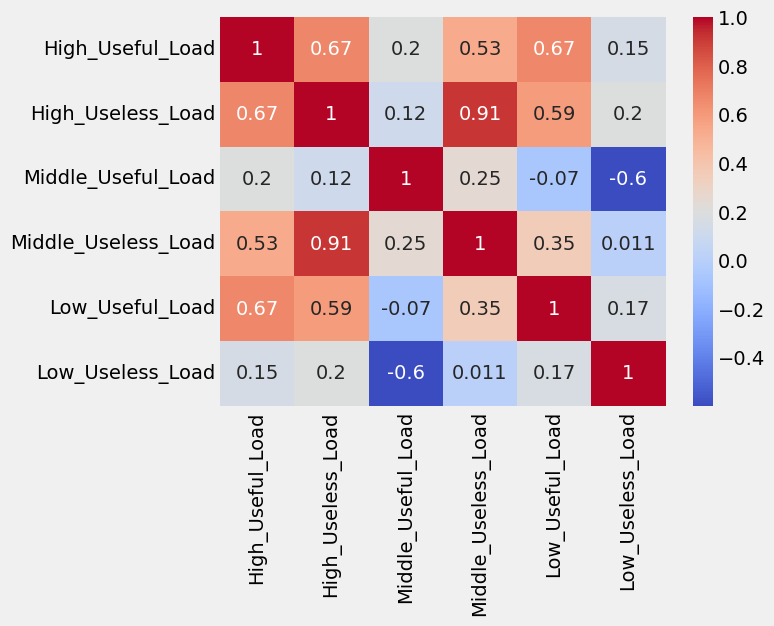

In [26]:
# Let us look at the correlation between possible external regressors

corrdf = df2.iloc[:,1:7].corr()
sns.heatmap(corrdf, annot=True, cmap='coolwarm')

<b><i>There is some positive as well as negative correlation among the variables. Our best option is to remove the correlated features by reducing dimensions via PCA.</i></b>

In [27]:
# Scale the values so that the difference in units is removed

dfindex =  df2.iloc[:,1:7].index

scaler = StandardScaler().set_output(transform='pandas')
scaled = scaler.fit_transform(df2.iloc[:,1:7])
scaled


,High_Useful_Load,High_Useless_Load,Middle_Useful_Load,Middle_Useless_Load,Low_Useful_Load,Low_Useless_Load
0,0.381768,0.651077,-0.560829,0.232275,1.276275,0.564707
1,0.234551,0.456755,-0.636775,0.048252,1.078856,0.555894
2,0.160942,0.331739,-0.727038,-0.172622,1.278063,0.555894
3,-0.166099,0.109396,-0.864538,0.085102,1.278063,0.548743
4,0.030126,0.262267,-0.759882,-0.184982,1.278063,0.548743
...,...,...,...,...,...,...
69675,0.537185,0.609460,0.777270,0.986909,-1.315207,0.110898
69676,0.160942,0.248339,0.459168,0.533030,-1.315207,0.110898
69677,0.234551,0.414972,0.504261,0.790755,-1.115999,0.110898
69678,0.316360,0.470516,0.610984,0.821425,-1.316994,0.110898


In [28]:
# PCA for feature reduction

pca = PCA(n_components=0.95, whiten=True)
features = pca.fit_transform(scaled)

In [29]:
# Checking number of features before PCA
print('Number of features before PCA: ', scaled.shape[1])

# Checking number of features after PCA
print('Number of features after PCA: ', features.shape[1])


Number of features before PCA:  6
Number of features after PCA:  4


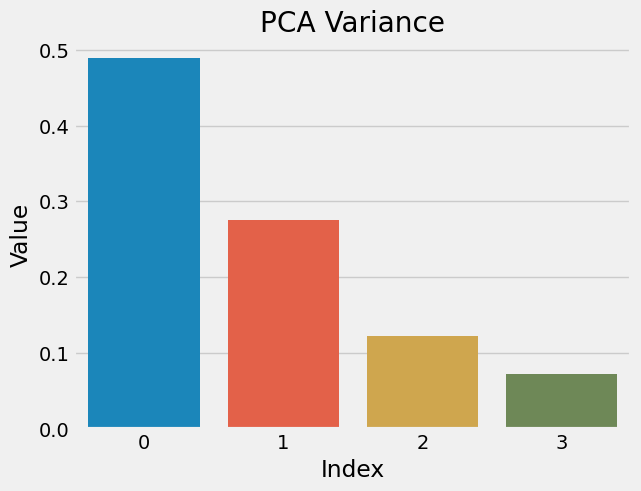

In [30]:
# Access the principal components
principal_components = pca.components_

# Access the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

x=np.arange(len(explained_variance_ratio))
ax=sns.barplot(x=x, y=explained_variance_ratio)

# Set labels and title
ax.set_xlabel('Index')
ax.set_ylabel('Value')
ax.set_title('PCA Variance')

plt.show()

<b><i>We could reduce 6 features down to 4 covering 95% of the underlying variance.</i></b>

In [31]:
# Create a new dataframe with the PCA results

df_pca = pd.DataFrame(data=features, columns=['PCA1','PCA2','PCA3','PCA4'], index=dfindex)
df_pca

,PCA1,PCA2,PCA3,PCA4
0,0.713817,-0.740325,0.537549,0.624599
1,0.500937,-0.773394,0.514461,0.583093
2,0.421759,-0.874632,0.811769,0.728531
3,0.320760,-0.913333,0.571185,1.098517
4,0.355718,-0.890168,0.786479,0.833755
...,...,...,...,...
69675,0.350723,0.651659,-1.566979,-1.417820
69676,-0.022347,0.424318,-1.329531,-1.119342
69677,0.179508,0.454094,-1.375931,-0.977799
69678,0.184850,0.541512,-1.520035,-1.213719


In [32]:
# Let us combine this with the original datetime and target variables

df_combined = df2[['ds','y']].merge(df_pca, how='inner', left_index=True, right_index=True)
df_combined

,ds,y,PCA1,PCA2,PCA3,PCA4
0,2016-07-01 00:00:00,38.661999,0.713817,-0.740325,0.537549,0.624599
1,2016-07-01 00:15:00,38.223000,0.500937,-0.773394,0.514461,0.583093
2,2016-07-01 00:30:00,37.344002,0.421759,-0.874632,0.811769,0.728531
3,2016-07-01 00:45:00,37.124001,0.320760,-0.913333,0.571185,1.098517
4,2016-07-01 01:00:00,37.124001,0.355718,-0.890168,0.786479,0.833755
...,...,...,...,...,...,...
69675,2018-06-26 18:45:00,45.986500,0.350723,0.651659,-1.566979,-1.417820
69676,2018-06-26 19:00:00,45.986500,-0.022347,0.424318,-1.329531,-1.119342
69677,2018-06-26 19:15:00,45.546501,0.179508,0.454094,-1.375931,-0.977799
69678,2018-06-26 19:30:00,45.546501,0.184850,0.541512,-1.520035,-1.213719


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0001267136976821348
         MAE_val            0.4733438491821289
        RMSE_val            0.6842164993286133
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          3.190048300893977e-05
         MAE_val            0.2820632755756378
        RMSE_val            0.36919087171554565
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.0007218157988972962
         MAE_val            1.7462847232818604
        RMSE_val            1.8172380924224854
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.0288021769374609
         MAE_val             10.0836763381958
        RMSE_val            10.530783653259277
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: 0it [00:00, ?it/s]

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test           0.00184740056283772
         MAE_val             2.907477617263794
        RMSE_val            2.9415509700775146
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


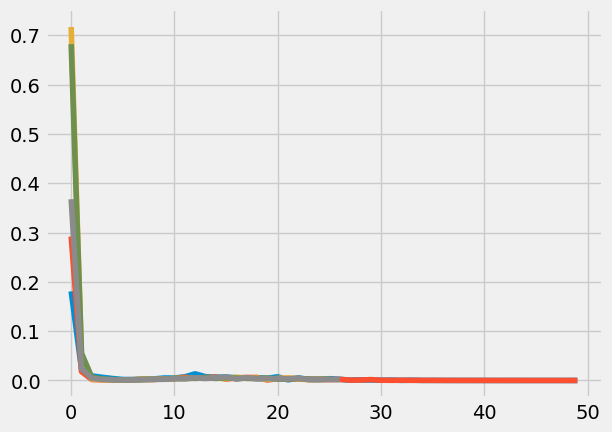

In [33]:
# Let us build the model with lagged regressors and autoregressor

Params = dict(yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', learning_rate=0.01, n_lags=100) # Dictionary storing key parameters for model
# Adding n_lags to capture autoregression

fitparams = dict(epochs=50, freq='15min', early_stopping=10, progress='plot') # Dictionary storing key parameters for fitting

# Disable logging messages unless there is an error
set_log_level("ERROR")

dfcv = NeuralProphet(**Params).crossvalidation_split_df(df_combined, k=5, fold_pct=0.2) # Splitting data into test and validation sets

summary_comb = pd.DataFrame()
metrics_comb = pd.DataFrame()
i=0

set_random_seed(50) # For reproducibility

for dftrain, dfval in dfcv: # Run for number of cross validation folds
     mp = NeuralProphet(**Params) # Initialize with yearly seasonality and learning rate
     mp.add_lagged_regressor('PCA1')
     mp.add_lagged_regressor('PCA2')
     mp.add_lagged_regressor('PCA3')
     mp.add_lagged_regressor('PCA4')
     summary_comb = pd.concat([summary_comb, mp.fit(dftrain, **fitparams)]) # Fitting model to training fold and storing results in summary df
          
     metrics_comb = pd.concat([metrics_comb,mp.test(dfval)]) # Validation for each fold and storing results in metrics df

     i=i+1

In [34]:
# Displaying the values after updating and training the model with autoregressor

statdisp(summary_comb, metrics_comb)

Training folds

               MAE        RMSE        Loss  RegLoss       epoch
count  179.000000  179.000000  179.000000    179.0  179.000000
mean     3.824721    4.507871    0.016062      0.0   19.279330
std      7.784739    9.628530    0.081918      0.0   13.317226
min      0.251205    0.359449    0.000031      0.0    0.000000
25%      1.701918    1.909894    0.000962      0.0    8.500000
50%      2.589015    2.987080    0.002464      0.0   17.000000
75%      3.501131    3.845104    0.004803      0.0   27.000000
max     64.130142   79.517960    0.716659      0.0   49.000000


Validation folds

          MAE_val   RMSE_val  Loss_test  RegLoss_test
count   5.000000   5.000000   5.000000           5.0
mean    3.098569   3.268596   0.006306           0.0
std     4.046030   4.184445   0.012597           0.0
min     0.282063   0.369191   0.000032           0.0
25%     0.473344   0.684216   0.000127           0.0
50%     1.746285   1.817238   0.000722           0.0
75%     2.907478   2.941

<b><i>Since the RMSE does not seem to improve and is slightly worse than before, we will proceed with the Autoregression only for final model, and ignore any lagged regressors.</i></b>

Training: 0it [00:00, ?it/s]

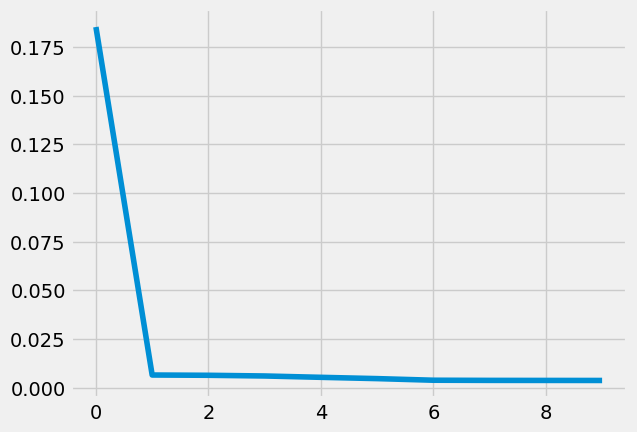

In [35]:
# Building the final model for forecasting

Paramsfinal = dict(yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', # Dictionary storing key parameters for model
    learning_rate=0.01, 
    n_lags=50, # Adding n_lags (autoregression)
    n_forecasts=672) # Adding n_forecasts per AR documentation here 
# (https://neuralprophet.com/how-to-guides/feature-guides/hyperparameter-selection.html?highlight=n_forecast)


fitparamsfinal = dict(epochs=10, freq='15min', early_stopping=10, progress='plot') # Dictionary storing key parameters for fitting

finalmodel = alldatamodel(Paramsfinal, fitparamsfinal)

In [36]:
# Plotting the parameters

fig=finalmodel.plot_parameters()
fig.update_layout(autosize=False, width=1200, height=800)

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': '#2d92ff', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> Trend <i style="color:#fc9944">~17h</i>',
              'type': 'scatter',
              'uid': 'eb3d5aee-aa80-4bad-a57b-64788b0b46cf',
              'x': array([datetime.datetime(2016, 7, 1, 0, 0),
                          datetime.datetime(2016, 7, 1, 16, 45),
                          datetime.datetime(2016, 7, 2, 10, 15), ...,
                          datetime.datetime(2018, 6, 26, 2, 0),
                          datetime.datetime(2018, 6, 26, 15, 30),
                          datetime.datetime(2018, 6, 26, 19, 45)], dtype=object),
              'xaxis': 'x',
              'y': array([42.60247432, 42.60656584, 42.61084057, ..., 37.36133886, 37.44605402,
                          37.47272361]),
              'yaxis': 'y'},
             {'marker': {'color': '#2d92ff'},
              

In [37]:
# Forecast future values from currently trained model

futuredf_final = finalmodel.make_future_dataframe(df2[['ds','y']], periods=672, n_historic_predictions=False) # forecasting 7 days ahead

forecast_final = finalmodel.predict(futuredf_final)

fig = finalmodel.plot(fcst=forecast_final)
fig.update_layout(autosize=False, width=1200, height=800)

Predicting: 1078it [00:00, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': 'origin-0',
              'type': 'scatter',
              'uid': 'd851c572-8ca4-4c41-a16e-bee4efcf71f0',
              'x': array([datetime.datetime(2018, 6, 26, 7, 30),
                          datetime.datetime(2018, 6, 26, 7, 45),
                          datetime.datetime(2018, 6, 26, 8, 0), ...,
                          datetime.datetime(2018, 7, 3, 19, 15),
                          datetime.datetime(2018, 7, 3, 19, 30),
                          datetime.datetime(2018, 7, 3, 19, 45)], dtype=object),
              'y': array([        nan,         nan,         nan, ..., 40.94868088, 40.65884018,
                          40.29486084])},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
              'name': 'Actual',
              'type': 'scatter',
              

<center><font size=6><b><i>Finally, we get an excellent prediction with associated nuances and seasonality!!</i></b></font><center><hr>